In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, PIL, pathlib
import numpy as np
import pandas as pd
import warnings
from tensorflow import keras

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [5]:
data_dir = '28-data'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print('图片总数:', image_count)

图片总数: 12000


In [7]:
batch_size = 16
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 12000 files belonging to 15 classes.
Using 9600 files for training.
Found 12000 files belonging to 15 classes.
Using 2400 files for validation.


In [10]:
class_names = train_ds.class_names

print('数据类别有:', class_names)
print('识别的水果一共%d类' % len(class_names))

数据类别有: ['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']
识别的水果一共15类


In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

def train_preprocessing(image, label):
    return (image/255.0, label)

train_ds = (
    train_ds.cache()
    .shuffle(2000)
    .map(train_preprocessing)
    # .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(2000)
    .map(train_preprocessing)
    # .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

In [ ]:
plt.figure(figsize=(10, 8))
plt.suptitle('数据展示')

for images, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]-1])

plt.show()

In [46]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation

base_model = keras.applications.ResNet50(weights='imagenet', # 使用在ImageNet上预训练的权重
                                         include_top=False,  # 不包含顶部的全连接层/分类器部分 只保留卷积基
                                         input_shape=(img_width, img_height, 3))

for layer in base_model.layers:
    layer.trainable = True # 通常设置为False 设置为True可进行微调

# 构建自定义顶层
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(len(class_names), activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [52]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 10
PATIENCE = 5
VERBOSE = 1

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))

earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)

checkpointer = ModelCheckpoint('best_26_model.weights.h5',
                               monitor='val_accuracy',
                               save_best_only=True,
                               save_weights_only=True)

In [58]:
train_model = model.fit(train_ds,
                        epochs=NO_EPOCHS,
                        verbose=1,
                        validation_data=val_ds,
                        callbacks=[earlystopper, checkpointer])

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2649s 4s/step - accuracy: 0.5120 - loss: 1.8420 - val_accuracy: 0.0733 - val_loss: 2.7145
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2113s 4s/step - accuracy: 0.6566 - loss: 1.5242 - val_accuracy: 0.9513 - val_loss: 1.0763
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2076s 3s/step - accuracy: 0.7123 - loss: 1.3571 - val_accuracy: 0.9883 - val_loss: 0.8115
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 2273s 4s/step - accuracy: 0.7513 - loss: 1.2272 - val_accuracy: 0.9958 - val_loss: 0.6329
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1834s 3s/step - accuracy: 0.7962 - loss: 1.0995 - val_accuracy: 0.9962 - val_loss: 0.4267
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1617s 3s/step - accuracy: 0.8305 - loss: 0.9762 - val_accuracy: 0.9958 - val_loss: 0.3004
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1597s 3s/step - accuracy: 0.8625 - loss: 0.8762 - val_accuracy: 0.9954 - val_loss: 0.2419
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1638s 3s/step - accuracy: 0.8780 - loss: 0.7886 - 

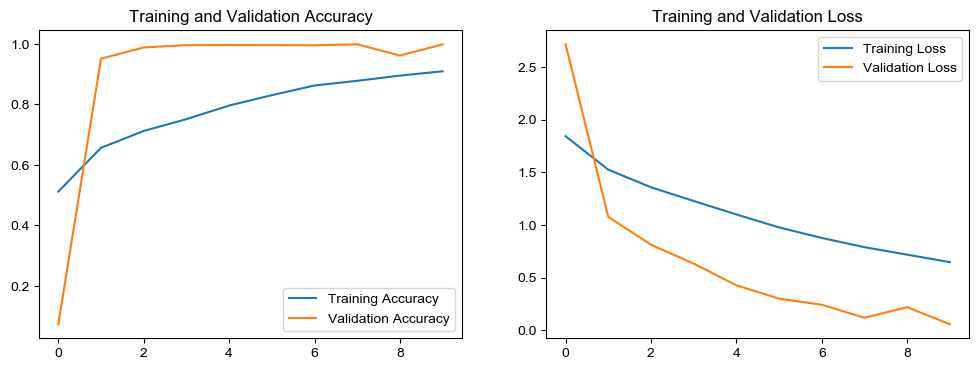

In [60]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_cm(labels, predictions):
    conf_numpy = confusion_matrix(labels, predictions)
    conf_df = pd.DataFrame(conf_numpy, index=class_names, columns=class_names)
    plt.figure(fig_size=(8, 7))
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='BuPu')
    plt.title('混淆矩阵', fontsize=15)
    plt.ylabel('真实值', fontsize=14)
    plt.xlabel('预测值', fontsize=14)

In [ ]:
val_pre = []
val_label = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        img_array = tf.expand_dims(image, 0)
        prediction = model.predict(img_array)
        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━

In [ ]:
plot_cm(val_label, val_pre)

In [ ]:
from sklearn import metrics

def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=class_names))
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])

test_accuracy_report(model)